# Spherical Deconvolution with Global Constraints

Constrained Spherical Deconvolution (CSD) *(Tournier et al. 2007)* is one of the most proven ways to estimate Fiber Orientation Distributions (FODs) that describe the orientation of the white matter tissue. In short, CSD's *single-shell* formulation states that any composition of oriented white matter (dispersion/crossings) can be described as the spherical convolution of a *positive* probability density on the sphere and a convolution kernel $K$ that describes one parallel axon bundle. With some abuse of notation:

$$
\begin{align}
\begin{aligned}
 E_{\textrm{CSD}}= \overbrace{\operatorname{FOD}(\textbf{c})}^{\textrm{Fiber Distribution}}\,*_{\mathbb{S}^2}\,\overbrace{K(\cdot)}^{\textrm{Convolution Kernel}}\quad\textrm{subject to}\quad \operatorname{FOD}(\textbf{c}) > 0.
\end{aligned}
\end{align}$$

Here, the FOD is described in terms of a truncated even spherical harmonics series $\operatorname{FOD}=\sum_{l=0}^{lmax}\sum_{m=-l}^l\textbf{c}_{lm}Y_{lm}$, with $l$ and $m$ describing the order and moment of the spherical harmonic *(Descoteaux et al. 2006)*. Furthermore, $*_{\mathbb{S}^2}$ describes a spherical convolution on the $\mathbb{S}^2$ sphere, and $K$ describes the *rotational* harmonics describing a single axon bundle. The kernel $K$ is typically estimated from the data *(Tournier et al. 2007, Tax et al. 2014)*, and CSD is therefore considered a *model-free* approach.

Here we will describe how the `MultiCompartmentSphericalHarmonicsModel` can be used to fit a CSD model using strict and global positivity constraints *(Dela Haije et al., 2020)*. Multi-compartment CSD models will be discussed in a different example.

## Multi-Shell Single-Compartment CSD

We will reproduce the standard CSD formulation, using only a single Zeppelin kernel describing a white matter bundle. Notice that in this model representation we must define the maximum spherical harmonics order at which to truncate the FOD.

In [1]:
from dmipy.core.modeling_framework import MultiCompartmentSphericalHarmonicsModel
from dmipy.signal_models import gaussian_models
zeppelin = gaussian_models.G2Zeppelin()
csd_mod = MultiCompartmentSphericalHarmonicsModel([zeppelin], sh_order=8)

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


### Response Function Estimation

Before fitting the FOD, we must first fix the parameters of the Zeppelin convolution kernel. First, we load our example slice of HCP data.

In [2]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


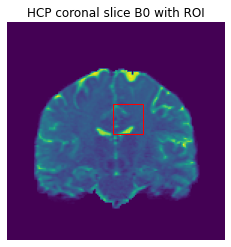

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin='lower')
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

We gratefully make use of Dipy's automatic response function estimation. We convert Dmipy's acquisition scheme to a Dipy gradient table using `gtab_dmipy2dipy`.

In [4]:
from dmipy.core.acquisition_scheme import gtab_dmipy2dipy
from dipy.reconst.csdeconv import auto_response_ssst
gtab = gtab_dmipy2dipy(scheme_hcp)
response, ratio = auto_response_ssst(gtab, data_hcp, roi_radii=10, fa_thr=0.7)
lambdas = response[0]
lambdas

array([0.00130163, 0.00024266, 0.00024266])

Notice that Dipy's response provides the Zeppelin's eigenvalues in mm$^2$/s, so we must first put them in SI units.

In [5]:
lambda_par = lambdas[0] * 1e-6
lambda_perp = lambdas[1] * 1e-6

We then fix the parameters of the kernel.

In [6]:
csd_mod.set_fixed_parameter('G2Zeppelin_1_lambda_par', lambda_par)
csd_mod.set_fixed_parameter('G2Zeppelin_1_lambda_perp', lambda_perp)

### Fitting CSD to HCP data and visualizing features

We are now ready to fit the CSD model as per usual. Using the default `solver='csd'` option will let the algorithm decide which optimizer to use - if volume fractions need to be estimated it will use `'csd_cvxpy'`, and otherwise the basic CSD `'csd_tournier07'` optimizer proposed by *(Tournier et al. 2007)*.

Using the `'csd'` option will also automatically select whether to enforce that the FOD integrates to one over the sphere (i.e. it is a proper distribution). If a non-voxel-varying convolution kernel is given, it will set `unity_constraint=False`, otherwise it will be set to `True`.

In [7]:
csd_fit = csd_mod.fit(
    acquisition_scheme=scheme_hcp,
    data=data_hcp,
    mask=data_hcp[..., 0]>0,
    solver='csd')

Setup Tournier07 FOD optimizer in 0.01994037628173828 seconds
Fitting of 8181 voxels complete in 17.824796199798584 seconds.
Average of 0.002178804082605865 seconds per voxel.


The `csd_fit` instance now constains the spherical harmonics of the FOD for every fitted voxel. For the used spherical harmonics order of $8$ that means we have estimated a total of 45 coefficients:

In [8]:
csd_fit.fitted_parameters_vector.shape

(145, 1, 145, 45)

We can estimate two metrics that quantify FOD anisotropy:
- The anisotropy index (AI) following *(Jespersen et al. 2007)*, ranging from 1 for completely anistropic, to zero being isotropic.
- The norm of the laplacian of the spherical harmonics of the FOD, explored in e.g. *(Descoteaux et al. 2006)*, which is zero for isotropic FODs and increasingly positive for more anistropic FODs.

It is relevant to note that AI is dependent on the value of the spherical mean of the FOD, but the Laplacian-norm is not.

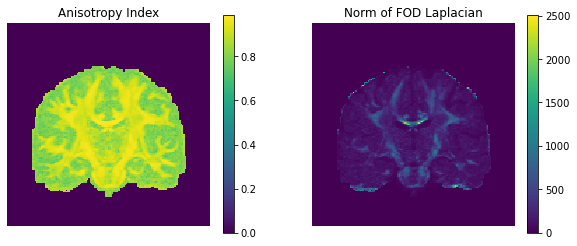

In [9]:
ai = csd_fit.anisotropy_index()
lb = csd_fit.norm_of_laplacian_fod()

fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs = axs.ravel()

for counter, (name, values) in enumerate(zip(['Anisotropy Index', 'Norm of FOD Laplacian'], [ai, lb])):
    cf = axs[counter].imshow(values.squeeze().T, origin='lower', interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)

As you can see, the AI and laplacian-norm anisotropy metrics have different contrasts: 
- AI shows well the constrast between white and grey matter, but not too much between different white matter areas.
- The laplacian-norm emphasizes anisotropic/coherent white matter areas, but does not show as clear the grey/white matter areas.

The CSD optimizer proposed by *(Tournier et al. 2007)* uses regularization to penalize negative values of the FODs in specific points. This results in sharp FODs, but does not strictly ensure positivity. We can instead use the setting `solver='csd_cvxpy'` to ensure positivity in these specific points without regularization, which  produces a more robust estimation with less sharp peaks, but at a higher computational cost. Finally we can use strict and global positivity constraints *(Dela Haije et al. 2020)* by using the setting `solver='csd_plus'`, which would be preferred when the accuracy of the estimation is more important than compuation time.

In [11]:
csd_plus_fit = csd_mod.fit(
    acquisition_scheme=scheme_hcp,
    data=data_hcp,
    mask=data_hcp[..., 0]>0,
    solver='csd_plus')

Setup CSD-PLUS FOD optimizer in 0.018807172775268555 seconds
Fitting of 8181 voxels complete in 4698.131550550461 seconds.
Average of 0.574273505751187 seconds per voxel.


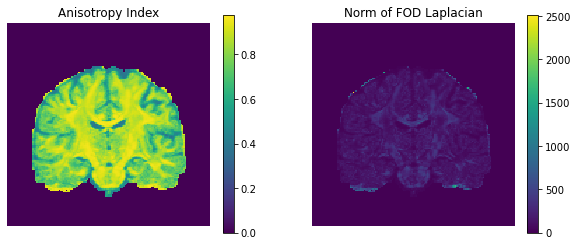

In [12]:
ai = csd_plus_fit.anisotropy_index()
lb = csd_plus_fit.norm_of_laplacian_fod()

fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs = axs.ravel()

for counter, (name, values) in enumerate(zip(['Anisotropy Index', 'Norm of FOD Laplacian'], [ai, lb])):
    cf = axs[counter].imshow(values.squeeze().T, origin='lower', interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)

### Visualizing Fiber Orientation Distributions

As before, we can again visualize the FOD estimated using CSD.

In [27]:
from dipy.data import get_sphere
from dipy.viz import window, actor
import numpy as np
from matplotlib import pyplot as plt

sphere = get_sphere(name='symmetric724')
fods = csd_fit.fod(sphere.vertices)

scene = window.Scene()
ren = actor.odf_slicer(fods[70:90,:, 70:90], sphere=sphere, colormap='plasma', scale=0.5)
ren.display(y=0)
ren.RotateX(-90)
scene.add(ren)
window.snapshot(scene, fname='fods.png', size=(600, 600));

We can likewise show the FODs based on the CSD+ reconstruction, which are guaranteed to be non-negative.

In [ ]:
fods = csd_plus_fit.fod(sphere.vertices)

scene = window.Scene()
ren = actor.odf_slicer(fods[70:90,:, 70:90], sphere=sphere, colormap='plasma', scale=0.5)
ren.display(y=0)
ren.RotateX(-90)
scene.add(ren)
window.snapshot(scene, fname='fods+.png', size=(600, 600));

Notice that in white matter the FODs are nicely shaped and we have a high AI, but in non-white matter they are very noisy and prominent. This is because the response function that we provided does not resemble the data in these areas, and we therefore get a non-sensical result, which is especially detrimental in partial-volumed voxels at the edge of the ventricles.

## References
- Dela Haije, Tom, Evren Özarslan, and Aasa Feragen. "Enforcing necessary non-negativity constraints for common diffusion MRI models using sum of squares programming." NeuroImage 209 (2020): 116405.
- Descoteaux, Maxime, et al. "Regularized, fast, and robust analytical Q‐ball imaging." Magnetic resonance in medicine 58.3 (2007): 497-510.
- Jespersen, Sune N., et al. "Modeling dendrite density from magnetic resonance diffusion measurements." Neuroimage 34.4 (2007): 1473-1486.
- Jeurissen, Ben, et al. "Multi-tissue constrained spherical deconvolution for improved analysis of multi-shell diffusion MRI data." NeuroImage 103 (2014): 411-426.
- Tax, Chantal MW, et al. "Recursive calibration of the fiber response function for spherical deconvolution of diffusion MRI data." Neuroimage 86 (2014): 67-80.
- Tournier, J-Donald, Fernando Calamante, and Alan Connelly. "Robust determination of the fibre orientation distribution in diffusion MRI: non-negativity constrained super-resolved spherical deconvolution." Neuroimage 35.4 (2007): 1459-1472.